## Image augmentation using keras ImageDataGenerator

In [1]:
# building data generator
from keras.preprocessing.image import ImageDataGenerator

base_path = "./images/"
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    rotation_range=5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    base_path + "train",
    target_size=(48, 48),
    subset="training",
    # color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
)

validation_generator = valid_datagen.flow_from_directory(
    base_path + 'train',
    target_size=(48, 48),
    # color_mode="grayscale",
    class_mode='categorical',
    subset='validation',
    batch_size=batch_size
)

test_data_generator = test_datagen.flow_from_directory(
    base_path + "validation",
    target_size=(48, 48),
    batch_size=batch_size,
    # color_mode="grayscale",
    class_mode='categorical',
)


2022-10-18 22:44:45.650379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 22:44:45.758616: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-18 22:44:46.390083: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.1/targets/x86_64-linux/lib:/usr/local/cuda-11.7/targets/x86_64-linux/lib
2022-10-18 22:44:46.390139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libr

Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Defining our 4 Convolution and 2 Dense layers model

In [2]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation
from keras.models import Sequential
from keras.applications import EfficientNetV2B0, ResNet50
from keras.optimizers import Adam
from keras import optimizers, layers

# number of possible label values
nb_classes = 7
IMAGE_SIZE = 48

base_model = EfficientNetV2B0(input_shape=(
    48, 48, 3), include_top=False, weights="imagenet")

model = Sequential([
    base_model,
    Dropout(0.5),
    Flatten(),
    BatchNormalization(),

    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dense(7, activation='softmax'),
])
model.summary()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


2022-10-18 22:44:47.733723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 22:44:47.757438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 22:44:47.757597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 22:44:47.758131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 2, 2, 1280)       5919312   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 2, 2, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 batch_normalization (BatchN  (None, 5120)             20480     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                163872    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               1

In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(verbose=1,patience=20)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=20, min_lr=1e-10)

In [4]:
# number of epochs to train the NN
from keras.callbacks import ModelCheckpoint
epochs = 100

# checkpoint to save best model
mcp = ModelCheckpoint('model.h5')
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[reduce_lr,es],
    verbose=1
)

Epoch 1/100


2022-10-18 22:44:55.899120: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


361/361 [==============================] - 31s 66ms/step - loss: 2.2239 - accuracy: 0.1412 - val_loss: 1.9929 - val_accuracy: 0.0894 - lr: 1.0000e-04
Epoch 2/100
361/361 [==============================] - 21s 59ms/step - loss: 2.0657 - accuracy: 0.1739 - val_loss: 1.9517 - val_accuracy: 0.1710 - lr: 1.0000e-04
Epoch 3/100
361/361 [==============================] - 21s 59ms/step - loss: 1.9905 - accuracy: 0.1941 - val_loss: 1.9150 - val_accuracy: 0.2182 - lr: 1.0000e-04
Epoch 4/100
361/361 [==============================] - 22s 61ms/step - loss: 1.9316 - accuracy: 0.2072 - val_loss: 1.8788 - val_accuracy: 0.2387 - lr: 1.0000e-04
Epoch 5/100
361/361 [==============================] - 21s 59ms/step - loss: 1.9000 - accuracy: 0.2170 - val_loss: 1.8553 - val_accuracy: 0.2387 - lr: 1.0000e-04
Epoch 6/100
361/361 [==============================] - 21s 59ms/step - loss: 1.8773 - accuracy: 0.2216 - val_loss: 1.8472 - val_accuracy: 0.2428 - lr: 1.0000e-04
Epoch 7/100
361/361 [===================

In [5]:
from matplotlib import pyplot as plt

# visualise training and testing accuracy and loss
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
 
# print best epoch with best accuracy on validation
def get_best_epoch(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc = max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))

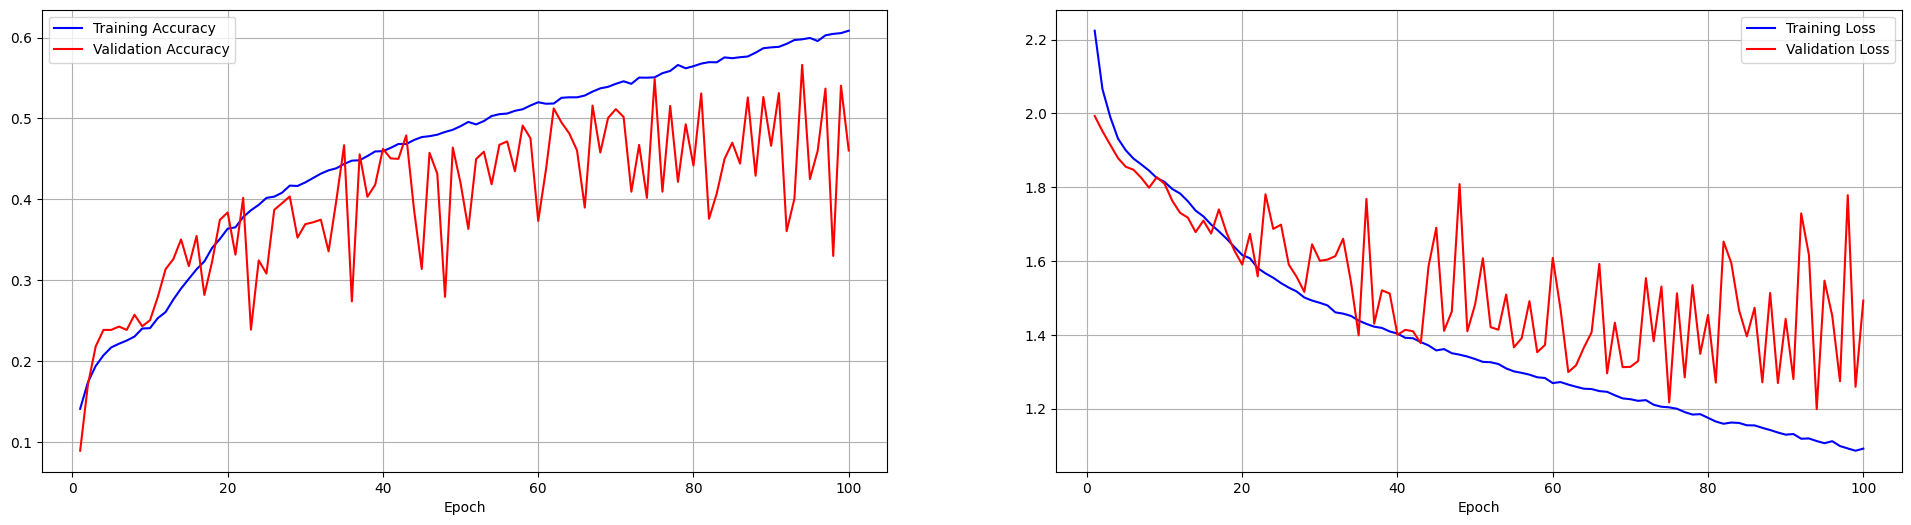

Best Validation Accuracy Score 0.56622, is for epoch 94


In [6]:
plot_results(history)
get_best_epoch(history)